# Compare MgSiO3 adiabats for different liquid models
* electronic contribution ignored due to bug in adiabatic calculation
* Compare RTpress dK09 and S11 models, as well as hybrid eos

In [1]:
%run core.ipynb

analysis = load_analysis()

datamodel = analysis['datamodel']
datamodel_dK09 = analysis['datamodel_dK09']
liq_eos_S11 = datamodel['eos_mod']
liq_eos_dK09 = datamodel_dK09['eos_mod']
liq_eos_S11.apply_electronic = False
liq_eos_dK09.apply_electronic = False

In [2]:
mgpv_eos = eoslib.MgPv_Mosenfelder2009()

In [3]:
liq_thermal_eos = liq_eos_S11
liq_compress_eos = liq_eos_dK09
sol_eos = mgpv_eos

## Adjust liquid entropies at well-constrained fusion location

In [4]:
P_fus0 = 25
T_fus0 = 2900
dS_fus0=1.5
Pmax = 150.0


Vsol_fus0 = volume(P_fus0, T_fus0, sol_eos)
S_sol0 = sol_eos.entropy(Vsol_fus0, T_fus0)
S_fus0 = S_sol0 + dS_fus0*CONSTS['kboltz']

In [5]:
adjust_fusion_entropy(liq_eos_dK09, S_fus0, P_fus0, T_fus0, Vinit=9)
adjust_fusion_entropy(liq_eos_S11, S_fus0, P_fus0, T_fus0, Vinit=9)
liq_eos_hybrid = HybridEos(liq_compress_eos, liq_thermal_eos, 
                       PTS_fus0=(P_fus0, T_fus0, S_fus0), fix_ref_adiabat=True)

S_fus0 diff =  [-5.42101086e-20]
S_fus0 diff =  [0.]


In [6]:
V_fus0_dK09 = volume(P_fus0, T_fus0, liq_eos_dK09, Vinit=9)
V_fus0_S11 = volume(P_fus0, T_fus0, liq_eos_S11, Vinit=9)

print('P_fus0 = ', liq_eos_dK09.press(V_fus0_dK09, T_fus0))
print('P_fus0 = ', liq_eos_S11.press(V_fus0_S11, T_fus0))

print('dS_fus0/kboltz = ', (liq_eos_dK09.entropy(V_fus0_dK09, T_fus0)-S_fus0)/CONSTS['kboltz'])
print('dS_fus0/kboltz = ', (liq_eos_S11.entropy(V_fus0_S11, T_fus0)-S_fus0)/CONSTS['kboltz'])

P_fus0 =  [25.]
P_fus0 =  [25.]
dS_fus0/kboltz =  [-6.2908228e-16]
dS_fus0/kboltz =  [0.]


## Integrate Adiabats

In [7]:
P_ad_hybrid, V_ad_hybrid, T_ad_hybrid = integrate_adiabat(
    P_fus0, T_fus0, liq_eos_hybrid, Pmin=0, Pmax=Pmax)

P_ad_dK09, V_ad_dK09, T_ad_dK09 = integrate_adiabat(
    P_fus0, T_fus0, liq_eos_dK09, Pmin=0, Pmax=Pmax)

P_ad_S11, V_ad_S11, T_ad_S11 = integrate_adiabat(
    P_fus0, T_fus0, liq_eos_S11, Pmin=0, Pmax=Pmax)


P_sol_ad, V_sol_ad, T_sol_ad = integrate_adiabat(
    P_fus0, T_fus0, sol_eos, Pmin=0, Pmax=Pmax)

# P_sol_ad = np.linspace(P_fus0, Pmax, 101)
# V_sol_ad, T_sol_ad = sol_eos.adiabatic_path(T_fus0, P_sol_ad)

<IPython.core.display.Javascript object>


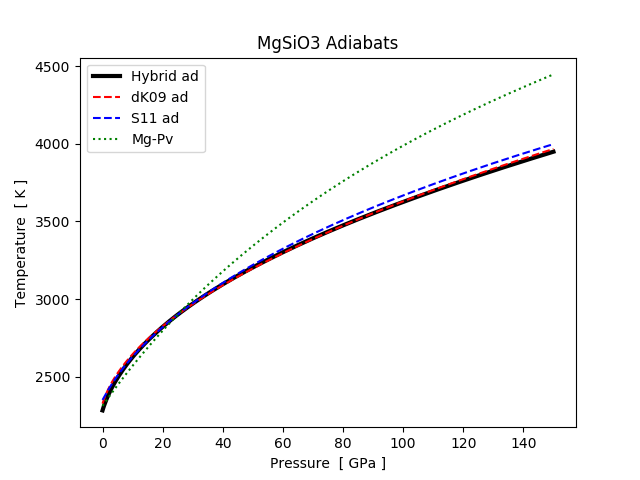

In [8]:
plt.figure()
plt.plot(P_ad_hybrid, T_ad_hybrid, 'k-', lw=3, label='Hybrid ad')
plt.plot(P_ad_dK09, T_ad_dK09, 'r--', label='dK09 ad')
plt.plot(P_ad_S11, T_ad_S11, 'b--', label='S11 ad')
plt.plot(P_sol_ad, T_sol_ad, 'g:', label='Mg-Pv')


plt.title('MgSiO3 Adiabats')
plt.xlabel('Pressure  [ GPa ]')
plt.ylabel('Temperature  [ K ]')
plt.legend()

## Validate consistency of adiabats 

In [9]:
S_ad_S11 = liq_eos_S11.entropy(V_ad_S11, T_ad_S11)
S_ad_dK09 = liq_eos_dK09.entropy(V_ad_dK09, T_ad_dK09)
S_ad_hybrid = liq_eos_hybrid.entropy(V_ad_hybrid, T_ad_hybrid)
S_sol_ad = sol_eos.entropy(V_sol_ad, T_sol_ad)


dS_ad_S11 = (S_ad_S11-np.mean(S_ad_S11))/(S_fus0-S_sol0)
dS_ad_dK09 = (S_ad_dK09-np.mean(S_ad_dK09))/(S_fus0-S_sol0)
dS_ad_hybrid = (S_ad_hybrid-np.mean(S_ad_hybrid))/(S_fus0-S_sol0)
dS_sol_ad = (S_sol_ad-np.mean(S_sol_ad))/(S_fus0-S_sol0)


<IPython.core.display.Javascript object>


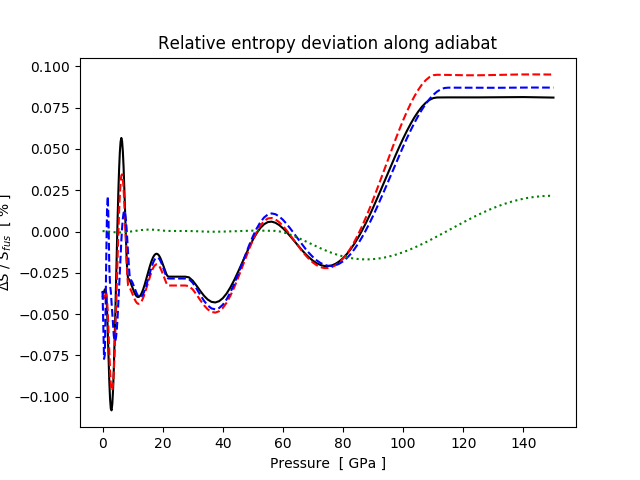

In [10]:
plt.figure()
plt.plot(P_ad_hybrid, 100*dS_ad_hybrid, 'k-')
plt.plot(P_ad_dK09, 100*dS_ad_dK09, 'r--')
plt.plot(P_ad_S11, 100*dS_ad_S11, 'b--')
plt.plot(P_sol_ad, 100*dS_sol_ad, 'g:')

plt.title('Relative entropy deviation along adiabat')
plt.xlabel('Pressure  [ GPa ]')
plt.ylabel('$\Delta S$ / $S_{fus}$  [ % ]')

In [11]:
analysis['liq_eos_hybrid'] = liq_eos_hybrid
analysis['liq_eos_S11'] = liq_eos_S11
analysis['liq_eos_dK09'] = liq_eos_dK09
analysis['sol_eos'] = sol_eos

analysis['P_fus0'] = P_fus0
analysis['T_fus0'] = T_fus0
analysis['dS_fus0'] = dS_fus0
analysis['S_fus0'] = S_fus0

save_analysis(analysis)